## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools

import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = [32, 128, 256]
PRE_ACTIVATE = [True, False]
MOMENTUM = 0.95

In [7]:
results={}
"""
撰寫訓練流程並將結果用 dictionary 紀錄
"""
for i, (use_preact, bs) in enumerate(itertools.product(PRE_ACTIVATE, BATCH_SIZE)):
    print("Numbers of exp: %i, use_preact: %s, batch_size: %i" % (i, use_preact, bs))
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate=use_preact)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bs, 
              validation_data=(x_test, y_test), 
              shuffle=True)         

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    exp_name_tag = "exp-pre-%s-bs-%s" % (str(use_preact),str(bs))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Numbers of exp: 0, use_preact: True, batch_size: 32
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activat

50000/50000 [==============================] - 4s 82us/step - loss: 0.7037 - accuracy: 0.7571 - val_loss: 1.6425 - val_accuracy: 0.4869
Epoch 11/20
50000/50000 [==============================] - 5s 95us/step - loss: 0.6374 - accuracy: 0.7827 - val_loss: 1.7688 - val_accuracy: 0.4674
Epoch 12/20
50000/50000 [==============================] - 5s 96us/step - loss: 0.5811 - accuracy: 0.8027 - val_loss: 1.9627 - val_accuracy: 0.4338
Epoch 13/20
50000/50000 [==============================] - 5s 94us/step - loss: 0.5228 - accuracy: 0.8242 - val_loss: 1.7269 - val_accuracy: 0.4897
Epoch 14/20
50000/50000 [==============================] - 5s 99us/step - loss: 0.4761 - accuracy: 0.8406 - val_loss: 1.8929 - val_accuracy: 0.4745
Epoch 15/20
50000/50000 [==============================] - 5s 94us/step - loss: 0.4337 - accuracy: 0.8545 - val_loss: 2.2230 - val_accuracy: 0.4500
Epoch 16/20
50000/50000 [==============================] - 5s 93us/step - loss: 0.3851 - accuracy: 0.8741 - val_loss: 2.0339

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 12s 240us/step - loss: 1.7409 - accuracy: 0.3816 - val_loss: 1.6285 - val_accuracy: 0.4183
Epoch 2/20
50000/50000 [==============================] - 11s 227us/step - loss: 1.5483 - accuracy: 0.4510 - val_loss: 1.5876 - val_accuracy: 0.4393
Epoch 3/20
50000/50000 [==============================] - 11s 223us/step - loss: 1.4719 - accuracy: 0.4768 - val_loss: 1.5500 - val_accuracy: 0.4477
Epoch 4/20
50000/50000 [==============================] - 11s 223us/step - loss: 1.4190 - accuracy: 0.4983 - val_loss: 1.5202 - val_accuracy: 0.4522
Epoch 5/20
50000/50000 [==============================] - 11s 217us/step - loss: 1.3843 - accuracy: 0.5100 - val_loss: 1.4362 - val_accuracy: 0.4876
Epoch 6/20
50000/50000 [==============================] - 11s 217us/step - loss: 1.3293 - accuracy: 0.5269 - val_loss: 1.5034 - val_accuracy: 0.4808
Epoch 7/20
50000/50000 [==============================] 

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 4s 74us/step - loss: 1.7054 - accuracy: 0.3971 - val_loss: 1.7753 - val_accuracy: 0.3909
Epoch 2/20
50000/50000 [==============================] - 3s 65us/step - loss: 1.4844 - accuracy: 0.4763 - val_loss: 1.6388 - val_accuracy: 0.4169
Epoch 3/20
50000/50000 [==============================] - 3s 65us/step - loss: 1.3944 - accuracy: 0.5070 - val_loss: 1.5246 - val_accuracy: 0.4562
Epoch 4/20
50000/50000 [==============================] - 3s 62us/step - loss: 1.3253 - accuracy: 0.5326 - val_loss: 1.5824 - val_accuracy: 0.4389
Epoch 5/20
50000/50000 [==============================] - 3s 58us/step - loss: 1.2644 - accuracy: 0.5533 - val_loss: 1.5440 - val_accuracy: 0.4548
Epoch 6/20
50000/50000 [==============================] - 3s 58us/step - loss: 1.2122 - accuracy: 0.5739 - val_loss: 1.4710 - val_accuracy: 0.4842
Epoch 7/20
50000/50000 [==============================] - 3s 58us/st

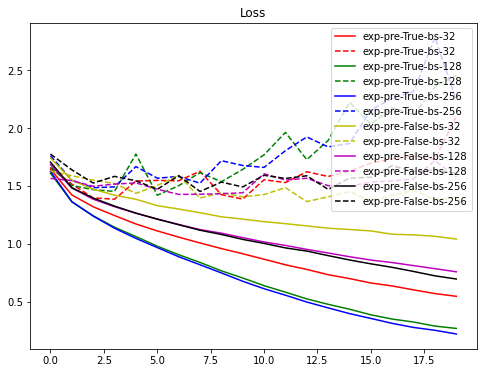

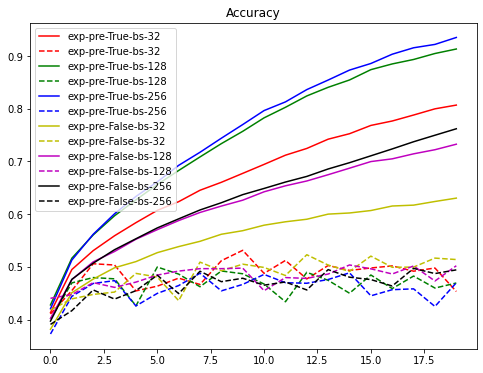

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

參考資源:
1. https://morvanzhou.github.io/tutorials/machine-learning/ML-intro/3-08-batch-normalization/
2. https://zhuanlan.zhihu.com/p/34879333